# Behaviour Driving

The goal of this project is to teach a virtual vehicle to drive using only the driving data that we have collected in a simulator. This idea is most recently based on a paper by NVIDIA called [End To End Driving For Self-Driving Cars](https://arxiv.org/abs/1604.07316).

## Loading The Dataset

In [17]:
# Visualizations will be shown in the notebook.
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2

In [57]:
path = '../datasets/behavioural_driving'
img_path = '../datasets/behavioural_driving/IMG'
models_path = "./models"

In [4]:
data_csv = pd.read_csv(path + '/driving_log.csv', header=None, 
                       names = ["Center", "Left", "Right", "Steering Angle", "Throttle", "Brake","Speed"])
data_csv.head(n=10)

,Center,Left,Right,Steering Angle,Throttle,Brake,Speed
0,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,0.000000,0.000000,0,3.159878e-06
1,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,0.000000,0.000000,0,3.875714e-07
2,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,0.000000,0.010726,0,2.983444e-02
3,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.094481,1.000000,0,9.546133e-01
4,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.094481,1.000000,0,2.342761e+00
5,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.094481,1.000000,0,3.502663e+00
6,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.094481,1.000000,0,4.441855e+00
7,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.094481,1.000000,0,5.833841e+00
8,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.094481,1.000000,0,6.523817e+00
9,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.148961,1.000000,0,7.435661e+00


In [19]:
img_count = data_csv.shape[0]
print("Dataset counts {0} rows".format(img_count))

Dataset counts 1042 rows


In [67]:
def read_img(img_name, path):
    img_path = "{0}/{1}".format(path, img_name)
    return cv2.imread(img_path)

In [68]:
# Let's import all our images and steering angles
X_train = np.zeros((img_count * 3, 160, 320, 3), dtype=np.uint8)
y_train = np.zeros((img_count * 3), dtype=np.float32)
for index, row in data_csv.iterrows():
    start_indx = index * 3
    for (i,pos) in enumerate(["Center","Left", "Right"]):
        img = read_img(row[pos].split("/")[-1], img_path)
        X_train[start_indx + i] = img
        y_train[start_indx + i] = row["Steering Angle"]
    #center_img_path = "{0}/{1}".format(img_path,row["Center"].split("/")[-1])
    #print(center_img_path)
    # OpenCV returns Height x Width x RGB
    #img = cv2.imread(center_img_path)
    #X_train[index] = img
    #y_train[index] = row["Steering Angle"]

In [69]:
print("Shape of training set images: {0}\nShape of training set labels: {1}".format(X_train.shape, y_train.shape))

Shape of training set images: (3126, 160, 320, 3)
Shape of training set labels: (3126,)


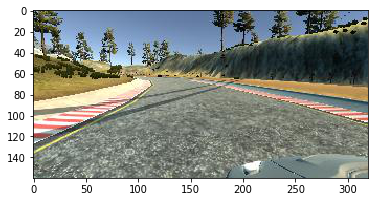

In [70]:
# Let's visualise an image
plt.imshow(cv2.cvtColor(X_train[100], cv2.COLOR_BGR2RGB), cmap=None)
plt.show()

## Build A Neural Net To Predict Steering Angles

We are using Keras, which in turn delegates to Tensorflow under the hood. Let's import all the functions we need.

In [123]:
# Initial Setup for Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [72]:
# Let's also define the input shape
in_shape = (160, 320, 3)

### Simple Model

In this section we create a simple model to predict steering angles. There are no convolutions in this architecture, and since this is a pure _regression_ problem, and not a _classification_ one, we will be using the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the activation function in the last layer.

In [77]:
def simple_model():
    model = Sequential()
    model.add(Flatten(input_shape=in_shape))
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = "adam", metrics=['accuracy'])
    return model

In [78]:
m = simple_model()
history = m.fit(X_train, y_train, nb_epoch=50, validation_split=0.2, shuffle=True, verbose=0)

In [66]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_acc'])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0047846889952153108, 0.0, 0.0095693779904306216, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0047846889952153108, 0.0, 0.0, 0.0, 0.0095693779904306216, 0.0047846889952153108, 0.0, 0.0, 0.0, 0.0, 0.0047846889952153108, 0.0047846890130396665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0047846889952153108, 0.0, 0.0, 0.0047846889952153108, 0.0047846889952153108]


In [80]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_loss'])

[21084.091385033946, 5162.5021910256091, 3336.7294165273065, 2661.4997425993411, 4334.0585921899956, 2931.8831720809203, 5767.068208054613, 2386.4748964157347, 1954.6100489217251, 6369.1227473542331, 1805.2955509466103, 8256.0578979882193, 1812.3054382519219, 1762.1040698164188, 1523.5546582499251, 1794.5441364129892, 2347.7099671775159, 3184.5184922873405, 1948.454331273088, 3321013.7428115015, 877065.70287539938, 60372.871655351439, 31081.517846445688, 63287.48497404153, 171630.6153154952, 309191.62914337061, 47877.987694688498, 283461.61861022364, 782862.09025559109, 492698.82547923323, 98549.914386980832, 85857.378344648561, 232147.39996006389, 902190.76996805111, 349112.241413738, 21909.791009384982, 181900.63064097444, 908597.79313099047, 760121.61281948886, 58112.869259185303, 194298.03783945687, 104528.26599940096, 5005818.2779552713, 36722.155975439295, 235452.51652356231, 141641.31055311501, 6716.3210254218247, 42497.774286142172, 125930.56150159745, 33481.090742312299]


In [81]:
m.save("{0}/simple_model.h5".format(models_path))

In [108]:
def plot_results(hist, metrics, xlb, ylb, title, leg, fsize = (10, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fsize)
    for m in metrics:        
        ax.plot(hist.history[m])
    
    ax.set(xlabel=xlb, ylabel=ylb, title=title)
    ax.set_yscale('log')

    ax.legend(leg, loc='upper left')
    plt.show()

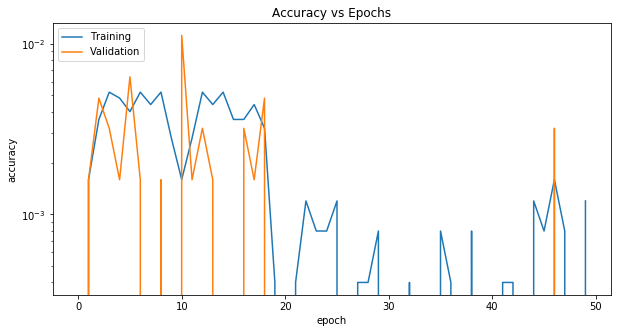

In [109]:
plot_results(history, ["acc", "val_acc"], "epoch", "accuracy", "Accuracy vs Epochs", ["Training", "Validation"])

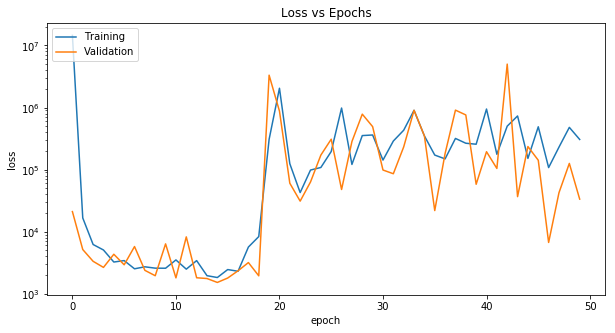

In [110]:
plot_results(history, ["loss", "val_loss"], "epoch", "loss", "Loss vs Epochs", ["Training", "Validation"])

We are not getting a stable network at all. The loss is erratic as well as the accuracy, and we are barely reaching 0.1% on the training set. We will explore next the architecture employed by the team from the NVIDIA paper.

## NVIDIA Model

In [132]:
def nvidia_model(target_shape):
    model = Sequential()
    
    model.add(BatchNormalization(input_shape=target_shape))
    # We have a series of 3 5x5 convolutional layers with a stride of 2x2
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))    
    
    # This is then followed by 2 3x3 convolutional layers with a 1x1 stride
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu'))    
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu'))  
    
    # Flattening the output of last convolutional layer before entering fully connected phase
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    
    # Output layer
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = "adam", metrics=['accuracy'])
    return model 

In [114]:
X_train = X_train.astype('float32')
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# Pre-compute mean, std, etc/
datagen.fit(X_train)

In [142]:
t_shape = (66,200,3)
m = nvidia_model(t_shape)

In [140]:
X_train_new = np.asarray(list(map(lambda x: cv2.resize(x, 
                                          (t_shape[1], t_shape[0]), 
                                          interpolation = cv2.INTER_AREA), X_train)))


Object `model.fit_generator` not found.


In [ ]:
# fits the model on batches with real-time data augmentation:
nhistory = m.fit(X_train_new, y_train, nb_epoch=50, validation_split=0.2, shuffle=True, verbose=1)

Train on 2500 samples, validate on 626 samples
Epoch 1/50
2500/2500 [==============================] - 2s - loss: 0.0133 - acc: 0.5784 - val_loss: 0.0056 - val_acc: 0.4217
Epoch 2/50
2500/2500 [==============================] - 2s - loss: 0.0103 - acc: 0.5784 - val_loss: 0.0037 - val_acc: 0.4217
Epoch 3/50
2500/2500 [==============================] - 2s - loss: 0.0086 - acc: 0.5784 - val_loss: 0.0053 - val_acc: 0.4217
Epoch 4/50
2500/2500 [==============================] - 2s - loss: 0.0066 - acc: 0.5784 - val_loss: 0.0042 - val_acc: 0.4217
Epoch 5/50
2500/2500 [==============================] - 2s - loss: 0.0054 - acc: 0.5784 - val_loss: 0.0108 - val_acc: 0.4217
Epoch 6/50
2500/2500 [==============================] - 2s - loss: 0.0051 - acc: 0.5784 - val_loss: 0.0081 - val_acc: 0.4217
Epoch 7/50
2500/2500 [==============================] - 2s - loss: 0.0040 - acc: 0.5784 - val_loss: 0.0057 - val_acc: 0.4217
Epoch 8/50
2500/2500 [==============================] - 2s - loss: 0.0028 - ac